This script is used to produce Figure 4 () for the Payne et al. paper "XXX"

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import xesmf as xe

In [15]:
vdir = 'ocn' # 'ocn' or 'ice'
vnam = 'photoC_diat_zint_2'#, 'photoC_diaz_zint', 'photoC_sp_zint']#,'photoC_diaz_zint','photoC_sp_zint'] # 'aice' # 'SST'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'

fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)


In [14]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [16]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
sa_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50 and ncfile["TLAT"][i,j] < 66.5:
            sa_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [4]:
max_25 = np.zeros([14,384,320,50]); max_100 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
npp_tot = np.zeros([14,384,320,50]); npp_bloom = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_100.txt")
    max_100[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_bloom.txt")
    npp_bloom[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_tot.txt")
    npp_tot[yrset,:,:,:] = dir.reshape(384,320,50)


In [5]:
max_25 = np.where(max_25==0, np.nan, max_25)
max_100 = np.where(max_100==0, np.nan, max_100)
max_25_2 = np.where(max_25_2==0, np.nan, max_25_2)
npp_bloom = np.where(npp_bloom==0, np.nan, npp_bloom)
npp_tot = np.where(npp_tot==0, np.nan, npp_tot)

In [6]:
# a. Read in a shapefile of the sea ice masks (perennial ice, seasonal ice, open water)
ds_simask = xr.open_dataset('/glade/u/home/cpayne/Projects/BloomLength/Input/simask.nc')
si_clim = ds_simask["si_clim"]
si_ens = ds_simask["si_ens"]

# load the xarray lat/lon files from pop grid
TLONG = ncfile.TLONG
TLAT = ncfile.TLAT

# Rename TLON and TLAT coordinates to be lon and lat so we can join them with sea ice data
TLONG = TLONG.rename({'nlon':'lon','nlat':'lat'})
TLAT =  TLAT.rename({'nlon':'lon','nlat':'lat'})

# reset sea ice lat/lon coordinates since TLON looks weird (above)
si_clim['TLON'] = TLONG
si_clim['TLAT'] = TLAT

si_ens['TLON'] = TLONG
si_ens['TLAT'] = TLAT

#Now rename TLON and TLAT coordinates to be lon and lat because regridders needs that specific naming
si_clim = si_clim.rename({'TLON':'lon','TLAT':'lat'})
si_ens = si_ens.rename({'TLON':'lon','TLAT':'lat'})

In [7]:
# Setting up a target grid 
# Do not include 90N and 90S otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat_new = np.arange(-89.5,90.0,0.5) 
lon_new = np.arange(0.0,361.0,1.0)

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon_new,lat_new) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

#input grid, output grid, method, keyword arguments
regridder = xe.Regridder(si_clim, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

# actually do the regridding
si_clim_regrid = regridder(si_clim)
si_ens_regrid = regridder(si_ens)

In [12]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = np.nanmean(vari2[i,j,:]) - np.nanmean(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_62695/3211699889.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_62695/3211699889.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  result = super().contourf(*args, **kwargs)


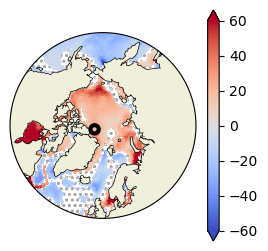

In [18]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none', edgecolor = 'grey',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
pc = ax.pcolormesh(lon, lat, varichange, 
                   transform=ccrs.PlateCarree(), vmin = -60, vmax = 60, cmap='coolwarm', zorder = 1);
# plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
# # plt.scatter(346.1,71.2,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Greenland
# plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
# plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =3) #Central Arctic
ax.coastlines();  ax.add_feature(cfeature.LAND,zorder=2); #plt.colorbar(pc, orientation='horizontal', extend='both');
plt.colorbar(pc, orientation='vertical', extend='both');
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4a.png';
figdir = '/glade/u/home/cpayne/Projects/BloomLength/PresentationFigs/Central.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


In [13]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = np.nanstd(vari2[i,j,:]) - np.nanstd(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_9854/3618265880.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_9854/3618265880.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


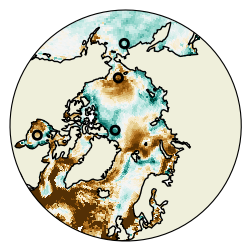

In [14]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, np.std(vari2,axis=2) - np.std(vari,axis=2), 
                   transform=ccrs.PlateCarree(), vmin = -20, vmax = 20, cmap='BrBG_r');   
plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
# plt.scatter(346.1,71.2,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Greenland
plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Central Arctic
ax.coastlines();  ax.add_feature(cfeature.LAND); #plt.colorbar(pc, orientation='horizontal', extend='both');
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4b.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# # plt.close()

In [8]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim1970 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*19700102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim1970[i,t,:,:] = dat[t,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
        else:
            for t in range(0,365):
                npp_clim1970[i,t,:,:] = dat[t,:,:] + npp_clim1970[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1231.018.pop.h.ecosys.nday1.photoC_diat_zint_2.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1301.016.pop.h.ecosys.nday1.photoC_diaz_zint_2.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_sp_zint_2/b.e21.BHISTsmbb.f09_g17.LE2-1251.019.pop.h.ecosys.nday1.photoC_sp_zint_2.19700102-19800101.nc


In [9]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim2020 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20150101*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim2020[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        else:
            for t in range(0,365):
                npp_clim2020[i,t,:,:] = dat[t+1825,:,:] + npp_clim2020[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1301.011.pop.h.ecosys.nday1.photoC_diat_zint_2.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1281.016.pop.h.ecosys.nday1.photoC_diaz_zint_2.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_sp_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1251.020.pop.h.ecosys.nday1.photoC_sp_zint_2.20150101-20250101.nc


In [10]:
## a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_2','photoC_diaz_zint_2','photoC_sp_zint_2']#['diatC_zint_100m', 'diazC_zint_100m', 'spC_zint_100m']# # 'aice' # 'SST'
npp_clim2100 = np.full([50, 365, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20950102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)
# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                npp_clim2100[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] #Get the year that is 5 years in (e.g. 2050)
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        else:
            for t in range(0,365):
                npp_clim2100[i,t,:,:] = dat[t+1825,:,:] + npp_clim2100[i,t,:,:]#dat[t+1825,:,:] + dat_clim[i,t,:,:] #Get the year that is 5 years in (e.g. 2050)
 

/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diat_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1281.012.pop.h.ecosys.nday1.photoC_diat_zint_2.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/photoC_diaz_zint_2/b.e21.BSSP370smbb.f09_g17.LE2-1251.018.pop.h.ecosys.nday1.photoC_diaz_zint_2.20950102-21001231.nc


Bering: 
i = 322; j=193; maxvl = .33; 
plt.yticks([0,0.05,0.1,0.15,0.2,y1970,y2020,y2100], labels = [0,0.05,0.1,0.15,0.2,1970,2020,2100])
Chukchi:
i = 342; j=194; maxvl = .082; 
plt.yticks([0,0.01,0.02,0.03,0.04,0.05,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,0.05,1970,2020,2100])
Hudson: 
i = 341; j=275; maxvl = .057; 
plt.yticks([0,0.01,0.02,0.03,0.04,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,1970,2020,2100])
Central: 
i = 372; j=176; maxvl = .064; 
plt.yticks([0,0.01,0.02,0.03,0.04,y1970,y2020,y2100], labels = [0,0.01,0.02,0.03,0.04,1970,2020,2100])
Greenland: 
i = 373; j = 40; maxvl = .175
plt.yticks([0,0.04,0.08,0.12,y1970,y2020,y2100], labels = [0,0.04,0.08,0.12,1970,2020,2100])


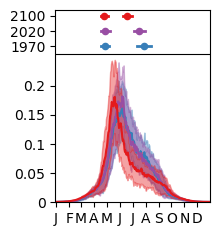

In [12]:
i = 322; j=193; maxvl = .33; 
y1970 = .81*maxvl; y2020 = .89*maxvl; y2100 = .97*maxvl; ln = .77*maxvl
rd = '#e41a1c'; pr = '#984ea3'; bl = '#377eb8'
mean_1970 = np.mean(npp_clim1970[:,:,i,j],axis=0); sd_1970 = np.std(npp_clim1970[:,:,i,j],axis=0)
mean_2020 = np.mean(npp_clim2020[:,:,i,j],axis=0); sd_2020 = np.std(npp_clim2020[:,:,i,j],axis=0)
mean_2100 = np.mean(npp_clim2100[:,:,i,j],axis=0); sd_2100 = np.std(npp_clim2100[:,:,i,j],axis=0)
meanstart_1970 = np.mean(max_25[0,i,j,:]); stdstart_1970 = np.std(max_25[0,i,j,:])
meanend_1970 = np.mean(max_25_2[0,i,j,:]); stdend_1970 = np.std(max_25_2[0,i,j,:])
meanstart_2020 = np.mean(max_25[5,i,j,:]); stdstart_2020 = np.std(max_25[5,i,j,:])
meanend_2020 = np.mean(max_25_2[5,i,j,:]); stdend_2020 = np.std(max_25_2[5,i,j,:])
meanstart_2100 = np.mean(max_25[13,i,j,:]); stdstart_2100 = np.std(max_25[13,i,j,:])
meanend_2100 = np.mean(max_25_2[13,i,j,:]); stdend_2100 = np.std(max_25_2[13,i,j,:])

fig = plt.figure(figsize=(2,2.5))
plt.fill_between(np.arange(1,366),mean_1970 - sd_1970, mean_1970 + sd_1970, 
                 color=bl,alpha=0.4)
plt.plot(np.arange(1,366),mean_1970, color=bl)

plt.fill_between(np.arange(1,366),mean_2020 - sd_2020, mean_2020 + sd_2020, 
                 color=pr,alpha=0.4)
plt.plot(np.arange(1,366),mean_2020, color=pr)

plt.fill_between(np.arange(1,366),mean_2100 - sd_2100, mean_2100 + sd_2100, 
                 color=rd,alpha=0.4)
plt.plot(np.arange(1,366),mean_2100, color=rd)

plt.plot([meanstart_1970-stdstart_1970,meanstart_1970+stdstart_1970],
         [y1970,y1970],color = bl, linewidth=2)
plt.plot([meanend_1970-stdend_1970,meanend_1970+stdend_1970],
         [y1970,y1970],color = bl, linewidth=2)
plt.scatter(meanstart_1970,y1970,color = bl, s=20)
plt.scatter(meanend_1970,y1970,color = bl, s=20)

plt.plot([meanstart_2020-stdstart_2020,meanstart_2020+stdstart_2020],
         [y2020,y2020],color = pr, linewidth=2)
plt.plot([meanend_2020-stdend_2020,meanend_2020+stdend_2020],
         [y2020,y2020],color = pr, linewidth=2)
plt.scatter(meanstart_2020,y2020,color = pr, s=20)
plt.scatter(meanend_2020,y2020,color = pr, s=20)

plt.plot([meanstart_2100-stdstart_2100,meanstart_2100+stdstart_2100],
         [y2100,y2100],color = rd, linewidth=2)
plt.plot([meanend_2100-stdend_2100,meanend_2100+stdend_2100],
         [y2100,y2100],color = rd, linewidth=2)
plt.scatter(meanstart_2100,y2100,color = rd, s=20)
plt.scatter(meanend_2100,y2100,color = rd, s=20)

plt.ylim(-.0001,maxvl); plt.xlim(-1,366)
plt.yticks([0,0.05,0.1,0.15,0.2,y1970,y2020,y2100], labels = [0,0.05,0.1,0.15,0.2,1970,2020,2100])
plt.xticks([1,32,60,91,121,152,182,213,244,274,305,335], labels = ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.plot([-1,367],[ln,ln],color='k',linewidth=.8)
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4c.png';
plt.savefig(figdir,facecolor='none', dpi = 600,bbox_inches="tight");
# plt.close()


In [28]:
# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
# i = 341; j = 275; # Hudson
# i = 372; j = 176; # Central
i = 373; j = 40;  # Greenland

print('Greenland')
print('Sea Ice 1970:', np.mean(si_ens[:,0,i,j]).values)
print('Sea Ice 2020:', np.mean(si_ens[:,5,i,j]).values)
print('Sea Ice 2100:', np.mean(si_ens[:,13,i,j]).values)
# print('Sea Ice 1970:', si_ens[:,0,i,j].values)
# print('Sea Ice 2020:', si_ens[:,5,i,j].values)
# print('Sea Ice 2100:', si_ens[:,13,i,j].values)
print('.')
print('Bloom Start',np.mean(max_25[0,i,j,:],axis=0),np.mean(max_25[5,i,j,:],axis=0),np.mean(max_25[13,i,j,:],axis=0),
     np.mean(max_25[13,i,j,:],axis=0)-np.mean(max_25[0,i,j,:],axis=0))
print(np.std(max_25[0,i,j,:],axis=0),np.std(max_25[5,i,j,:],axis=0),np.std(max_25[13,i,j,:],axis=0))
print(stats.ttest_rel(max_25[0,i,j,:], max_25[5,i,j,:]))
print(stats.ttest_rel(max_25[0,i,j,:], max_25[13,i,j,:]))
print('.')
print('Bloom End',np.mean(max_25_2[0,i,j,:],axis=0),np.mean(max_25_2[5,i,j,:],axis=0),np.mean(max_25_2[13,i,j,:],axis=0),
     np.mean(max_25_2[13,i,j,:],axis=0)-np.mean(max_25_2[0,i,j,:],axis=0))
print(np.std(max_25_2[0,i,j,:],axis=0),np.std(max_25_2[5,i,j,:],axis=0),np.std(max_25_2[13,i,j,:],axis=0))
print(stats.ttest_rel(max_25_2[0,i,j,:], max_25_2[5,i,j,:]))
print(stats.ttest_rel(max_25_2[0,i,j,:], max_25_2[13,i,j,:]))
print('.')
print('Bloom Length',np.mean(max_25_2[0,i,j,:]-max_25[0,i,j,:],axis=0),np.mean(max_25_2[5,i,j,:]-max_25[5,i,j,:],axis=0),np.mean(max_25_2[13,i,j,:]-max_25[13,i,j,:],axis=0),
     np.mean(max_25_2[13,i,j,:]-max_25[13,i,j,:],axis=0)-np.mean(max_25_2[0,i,j,:]-max_25[0,i,j,:],axis=0))
print(np.std(max_25_2[0,i,j,:]-max_25[13,i,j,:],axis=0),np.std(max_25_2[13,i,j,:]-max_25[0,i,j,:],axis=0))
print(stats.ttest_rel(max_25_2[0,i,j,:]-max_25[0,i,j,:], max_25_2[5,i,j,:]-max_25[5,i,j,:]))
print(stats.ttest_rel(max_25_2[0,i,j,:]-max_25[0,i,j,:], max_25_2[13,i,j,:]-max_25[13,i,j,:]))
print('.')
print('Bloom NPP',np.mean(npp_bloom[0,i,j,:],axis=0),np.mean(npp_bloom[5,i,j,:],axis=0),np.mean(npp_bloom[13,i,j,:],axis=0))
print(np.std(npp_bloom[0,i,j,:],axis=0),np.std(npp_bloom[5,i,j,:],axis=0),np.std(npp_bloom[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:],npp_bloom[5,i,j,:]))
print(stats.ttest_rel(npp_bloom[0,i,j,:],npp_bloom[13,i,j,:]))
print('.')
print('Daily Bloom NPP',np.mean(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),axis=0),
                                np.mean(npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:]),axis=0),
                                np.mean(npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:]),axis=0))
print(np.std(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),axis=0),np.std(npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:]),axis=0),
      np.std(npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:]),axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),npp_bloom[5,i,j,:]/(max_25_2[5,i,j,:]-max_25[5,i,j,:])))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/(max_25_2[0,i,j,:]-max_25[0,i,j,:]),npp_bloom[13,i,j,:]/(max_25_2[13,i,j,:]-max_25[13,i,j,:])))
print('.')
print('Tot NPP',np.mean(npp_tot[0,i,j,:],axis=0),np.mean(npp_tot[5,i,j,:],axis=0),np.mean(npp_tot[13,i,j,:],axis=0))
print(np.std(npp_tot[0,i,j,:],axis=0),np.std(npp_tot[5,i,j,:],axis=0),np.std(npp_tot[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_tot[0,i,j,:],npp_tot[5,i,j,:]))
print(stats.ttest_rel(npp_tot[0,i,j,:],npp_tot[13,i,j,:]))
print('.')
print('Prop. Bloom NPP',np.mean(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],axis=0),np.mean(npp_bloom[5,i,j,:]/npp_tot[5,i,j,:],axis=0),
      np.mean(npp_bloom[13,i,j,:]/npp_tot[13,i,j,:],axis=0))
print(np.std(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],axis=0),np.std(npp_bloom[5,i,j,:]/npp_tot[5,i,j,:],axis=0),np.std(npp_bloom[13,i,j,:]/npp_tot[13,i,j,:],axis=0))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],npp_bloom[5,i,j,:]/npp_tot[5,i,j,:]))
print(stats.ttest_rel(npp_bloom[0,i,j,:]/npp_tot[0,i,j,:],npp_bloom[13,i,j,:]/npp_tot[13,i,j,:]))


Greenland
Sea Ice 1970: 1.0
Sea Ice 2020: 1.0
Sea Ice 2100: 0.14
.
Bloom Start 157.58 146.86 90.96 -66.62000000000002
12.510939213344455 10.469020966642487 12.486728955174769
TtestResult(statistic=5.1723244218088205, pvalue=4.2728531363916795e-06, df=49)
TtestResult(statistic=24.716123308668116, pvalue=2.5322330744397257e-29, df=49)
.
Bloom End 231.04 212.56 172.7 -58.34
19.347309890524834 19.58587245950509 32.99166561421233
TtestResult(statistic=5.0133148518373725, pvalue=7.3906262215337664e-06, df=49)
TtestResult(statistic=10.164921648115378, pvalue=1.1663322805198425e-13, df=49)
.
Bloom Length 73.46 65.7 81.74 8.280000000000001
23.81498687801444 33.506799309990804
TtestResult(statistic=2.4132394890203086, pvalue=0.019596379383371616, df=49)
TtestResult(statistic=-1.412565880245038, pvalue=0.1641036790736959, df=49)
.
Bloom NPP 29.073962470004943 28.275836631002367 36.38982795852874
8.655010455480694 7.947148974348413 22.050267928078156
TtestResult(statistic=0.4685218196150492, pvalu

In [16]:
70/105

0.6666666666666666

In [31]:
fdir

'/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/day_1/aice_d/'

In [8]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_1970 = np.full([50, 365, 384, 320], np.nan)
fswdn_1970 = np.full([50, 365, 384, 320], np.nan)
aice_1970 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*19700102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_1970[i,t,:,:] = dat[t,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_1970[i,t,:,:] = dat[t,:,:] 
        else:
            for t in range(0,365):
                aice_1970[i,t,:,:] = dat[t,:,:] 
        

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BHISTsmbb.f09_g17.LE2-1231.017.cice.h1.fswthru_d.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BHISTsmbb.f09_g17.LE2-1251.016.cice.h1.fswdn_d.19700102-19800101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BHISTsmbb.f09_g17.LE2-1071.004.cice.h1.aice_d.19700102-19800101.nc


In [9]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_2020 = np.full([50, 365, 384, 320], np.nan)
fswdn_2020 = np.full([50, 365, 384, 320], np.nan)
aice_2020 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20150101*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_2020[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_2020[i,t,:,:] = dat[t+1825,:,:] 
        else:
            for t in range(0,365):
                aice_2020[i,t,:,:] = dat[t+1825,:,:] 
        

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BSSP370smbb.f09_g17.LE2-1191.010.cice.h1.fswthru_d.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BSSP370smbb.f09_g17.LE2-1281.015.cice.h1.fswdn_d.20150101-20250101.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BSSP370smbb.f09_g17.LE2-1251.020.cice.h1.aice_d.20150101-20250101.nc


In [10]:
# a. Select variable of interest and locate the files
vdir = 'ice' # 'ocn' or 'ice'
vnam = ['fswthru_d', 'fswdn_d', 'aice_d']
fswthru_2100 = np.full([50, 365, 384, 320], np.nan)
fswdn_2100 = np.full([50, 365, 384, 320], np.nan)
aice_2100 = np.full([50, 365, 384, 320], np.nan)

for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1
    
# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*20950102*"): #use suffix 0102 for every year but 2015 and 0101 for 2015.
        i = i + 1
        if i == 0:
            print(file)

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,365):
                fswthru_2100[i,t,:,:] = dat[t+1825,:,:]#[t+1825,:,:] 
            #dat_diat[i,:,:] = np.nansum(dat[1825:3650,:,:], axis = 0)
        elif j == 1:
            for t in range(0,365):
                fswdn_2100[i,t,:,:] = dat[t+1825,:,:] 
        else:
            for t in range(0,365):
                aice_2100[i,t,:,:] = dat[t+1825,:,:] 
        

/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswthru_d/b.e21.BSSP370smbb.f09_g17.LE2-1151.008.cice.h1.fswthru_d.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/fswdn_d/b.e21.BSSP370smbb.f09_g17.LE2-1151.008.cice.h1.fswdn_d.20950102-21001231.nc
/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/day_1/aice_d/b.e21.BSSP370smbb.f09_g17.LE2-1231.015.cice.h1.aice_d.20950102-21001231.nc


(1.0, 366.0)

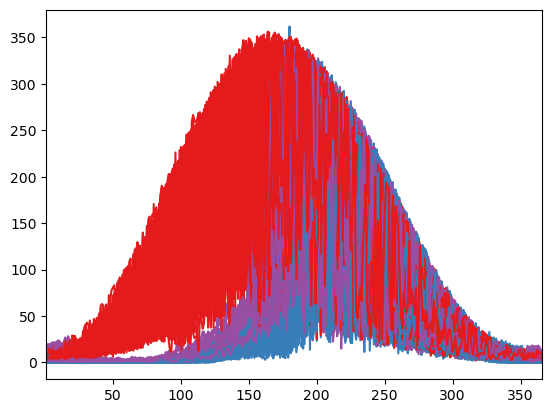

In [64]:
rd = '#e41a1c'; pr = '#984ea3'; bl = '#377eb8'
# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
i = 341; j = 275; # Hudson
# i = 372; j = 176; # Central

propswi_2100 = np.zeros([50,365]); propswi_2020 = np.zeros([50,365]); propswi_1970 = np.zeros([50,365]); 

propswi_2100 = (fswthru_2100[:,:,i,j]*aice_2100[:,:,i,j] + fswdn_2100[:,:,i,j]*(1-aice_2100[:,:,i,j]))#/(fswdn_2100[:,:,i,j])
propswi_2020 = (fswthru_2020[:,:,i,j]*aice_2020[:,:,i,j] + fswdn_2020[:,:,i,j]*(1-aice_2020[:,:,i,j]))#/(fswdn_2020[:,:,i,j])
propswi_1970 = (fswthru_1970[:,:,i,j]*aice_2100[:,:,i,j] + fswdn_1970[:,:,i,j]*(1-aice_1970[:,:,i,j]))#/(fswdn_1970[:,:,i,j])

for ens in np.arange(0,50):
    plt.plot(np.arange(1,366),propswi_1970[ens,:], color = bl)
    plt.plot(np.arange(1,366),propswi_2020[ens,:], color = pr)
    plt.plot(np.arange(1,366),propswi_2100[ens,:], color = rd)
plt.xlim(1,366)
#plt.ylim(0,1.01); plt.xlim(1,366)


In [61]:
prop_max_25_1970 = np.zeros([50]); prop_max_25_2020 = np.zeros([50]); prop_max_25_2100 = np.zeros([50]); 
for ens in np.arange(0,50):
    t = max_25[0,i,j,ens]
    prop_max_25_1970[ens] = propswi_1970[ens,int(t)]
    t = max_25[8,i,j,ens]
    prop_max_25_2020[ens] = propswi_2020[ens,int(t)]
    t = max_25[13,i,j,ens]
    prop_max_25_2100[ens] = propswi_2100[ens,int(t)]


In [33]:
print("Bering", np.mean(prop_max_25_1970), np.std(prop_max_25_1970),
      np.mean(prop_max_25_2020), np.std(prop_max_25_2020),
      np.mean(prop_max_25_2100), np.std(prop_max_25_2100))
# plt.scatter(np.arange(0,50),prop_max_25_1970, color = bl)
# plt.scatter(np.arange(0,50),prop_max_25_2020, color = pr)
# plt.scatter(np.arange(0,50),prop_max_25_2100, color = rd)

Bering 118.58513147840073 51.38897052954444 119.7001012130922 58.182837582303 139.03543140411378 61.30782905607982


In [65]:
prop_max_25_1970 = np.zeros([50]); prop_max_25_2020 = np.zeros([50]); prop_max_25_2100 = np.zeros([50]); 
for ens in np.arange(0,50):
    for t in np.arange(0,365):
        if propswi_1970[ens,t] > 4.5:
            prop_max_25_1970[ens] = prop_max_25_1970[ens] + 1
        if propswi_2020[ens,t] > 4.5:
            prop_max_25_2020[ens] = prop_max_25_2020[ens] + 1
        if propswi_2100[ens,t] > 4.5:
            prop_max_25_2100[ens] = prop_max_25_2100[ens] + 1


In [67]:
335.9-351.5

-15.600000000000023

In [66]:
print(np.mean(prop_max_25_1970), np.std(prop_max_25_1970),
      # np.mean(prop_max_25_2020), np.std(prop_max_25_2020),
      np.mean(prop_max_25_2100), np.std(prop_max_25_2100),
      stats.ttest_rel(prop_max_25_1970, prop_max_25_2020),
      stats.ttest_rel(prop_max_25_1970, prop_max_25_2100))
# plt.scatter(np.arange(0,50),prop_max_25_1970, color = bl)
# plt.scatter(np.arange(0,50),prop_max_25_2020, color = pr)
# plt.scatter(np.arange(0,50),prop_max_25_2100, color = rd)

224.68 10.310072744651222 349.04 3.5211361802690906 TtestResult(statistic=-13.187021377408666, pvalue=9.713791126912745e-18, df=49) TtestResult(statistic=-77.92703726998259, pvalue=4.87388570293916e-53, df=49)


In [91]:
print(np.sum(np.mean(fswdn_1970[:,:,i,j],axis=0),axis=0),
      np.sum(np.mean(fswdn_2100[:,:,i,j],axis=0),axis=0),
     )

29289.61960211754 22659.437492175763


In [76]:
print(np.sum(np.mean(propswi_1970,axis=0),axis=0),
      np.sum(np.mean(propswi_2100,axis=0),axis=0))

2132.4783990854153 8678.973106500827


In [80]:
# 1970 -> 2100 light in ocean
# 26328.915589505807, 28375.57698003292 #Bering
# 6877.3922819073, 18478.240830185976 #Chukchi
# 14490.934688107247, 37007.70017660089 #Hudson
# 2132.4783990854153, 8678.973106500827 #Central

# 1970 -> 2100 downwelling light
# 26748.582878513334, 28375.57698003292 #Bering
# 29104.539708111246, 23903.11360098971 #Chukchi
# 41125.000315600635, 37481.25451727152 #Hudson
# 29289.61960211754, 22659.437492175763 #Central


3.069899657704901

In [94]:
a = [26748.582878513334, 28375.57698003292, #Bering
     29104.539708111246, 23903.11360098971, #Chukchi
     41125.000315600635, 37481.25451727152, #Hudson
     29289.61960211754, 22659.437492175763]
a/np.max(a)

array([0.65042146, 0.68998363, 0.70770917, 0.58123072, 1.        ,
       0.91139828, 0.71220959, 0.55098936])

In [83]:
8700/37000

0.23513513513513515

In [23]:
np.nansum(np.nanmean(npp_bloom[13,:,:,:],axis=2)*sa_ocn/np.nanmean(npp_tot[13,:,:,:],axis=2)/np.nansum(sa_ocn))

/glade/derecho/scratch/cpayne/tmp/ipykernel_62279/223539987.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(npp_bloom[13,:,:,:],axis=2)*sa_ocn/np.nanmean(npp_tot[13,:,:,:],axis=2)/np.nansum(sa_ocn))


0.45049044639456903

In [19]:
npp_bloom.shape

(14, 384, 320, 50)